<!-- <table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/DrPBaksh/image_processing/main/logos/logo_2.png?raw=true" alt="Corndel" width="301.5" height="216"></td>
    <td><img src="https://github.com/CorndelDataAnalyticsDiploma/workshop/blob/master/Corndel%20Digital%20Logo%20Centre.png?raw=true" alt="Corndel" width="301.5" height="216"></td>
  </tr>
</table> -->


<img src="https://raw.githubusercontent.com/DrPBaksh/image_processing/main/logos/logo_2.png?raw=true" alt="Corndel" width ="301.5" height=216>

<!-- <img src="https://github.com/CorndelDataAnalyticsDiploma/workshop/blob/master/Corndel%20Digital%20Logo%20Centre.png?raw=true" alt="Corndel" width ="301.5" height=216> -->

# Detection Sitting, Standing, Walking and Running from 1D Accelerometer Data

In [72]:
import pandas as pd
# General packages
import pandas as pd
import numpy as np
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# sklearn models used below
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# sklearn data splitting
from sklearn.model_selection import train_test_split

# sklearn pre-processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# sklearn hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# sklearn tree plotting
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.tree import export_graphviz

# feature importance
from sklearn.inspection import permutation_importance

# sklearn model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay



import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
from tqdm import tqdm

**Import the datasets below**

In [78]:

df = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/motion_classification/atx.csv?raw=true', header = None)
df.shape

(44, 7776)

In [68]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,7766,7767,7768,7769,7770,7771,7772,7773,7774,7775
0,-73.394,-73.394,-73.396,-73.424,-73.344,-73.327,-73.405,-73.292,-73.321,-73.454,...,-44.397,-89.3460,-62.821,-89.8150,63.104,-3.2662,-14.1230,37.933,5.4417,16.805
1,-73.474,-73.400,-73.293,-73.513,-73.341,-73.368,-73.465,-73.330,-73.465,-73.361,...,-72.396,5.4608,110.010,-5.6971,-14.744,-9.6048,-8.3159,-42.170,5.6751,-35.210


In [69]:
df = df.transpose() # make rows columns and columns rows

In [70]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,-73.394,-73.474,-73.485,-73.546,-73.294,-73.547,-73.523,-73.227,-73.312,-73.262,...,-73.656,-73.322,-73.460,-73.447,-73.352,-73.443,-73.366,-73.456,-73.484,-73.387
1,-73.394,-73.400,-73.513,-73.529,-73.322,-73.460,-73.447,-73.352,-73.443,-73.366,...,-73.399,-73.424,-73.484,-73.387,-73.394,-73.400,-73.513,-73.529,-73.438,-73.387


**Bring in the id names dataset**

In [83]:
act_id = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/motion_classification/actid.csv?raw=true', header = None).rename(columns = {0:'id'})
act_id.head()

,id
0,1
1,1
2,1
3,1
4,1


**Look at the amount of sampes in each class. There is not huge variation so we shall leave this for now**

In [8]:
act_id.value_counts() 

id
2     2259
1     2127
3     1957
4     1433
dtype: int64

**Looking at what is in the names file**

In [80]:
act_names = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/motion_classification/actnames.csv?raw=true', header = None)
row_str = act_names.iloc[0].apply(lambda x: str(x)).str.cat(sep=' ')
row_str

'S i t t i n g S t a n d i n g W a l k i n g R u n n i n g'

**Create a dictionary of values that turn our ids to names and names to ids. This could be useful later**

In [10]:
id_2_name = {1: 'sitting', 2: 'standing', 3: 'walking', 4: 'running'}
name_2_id = { 'sitting': 1,  'standing':2,  'walking':3,  'running':4}

In [11]:
df_array = df.values

**Here we are viewing 20 random examples to get a feel for the data**

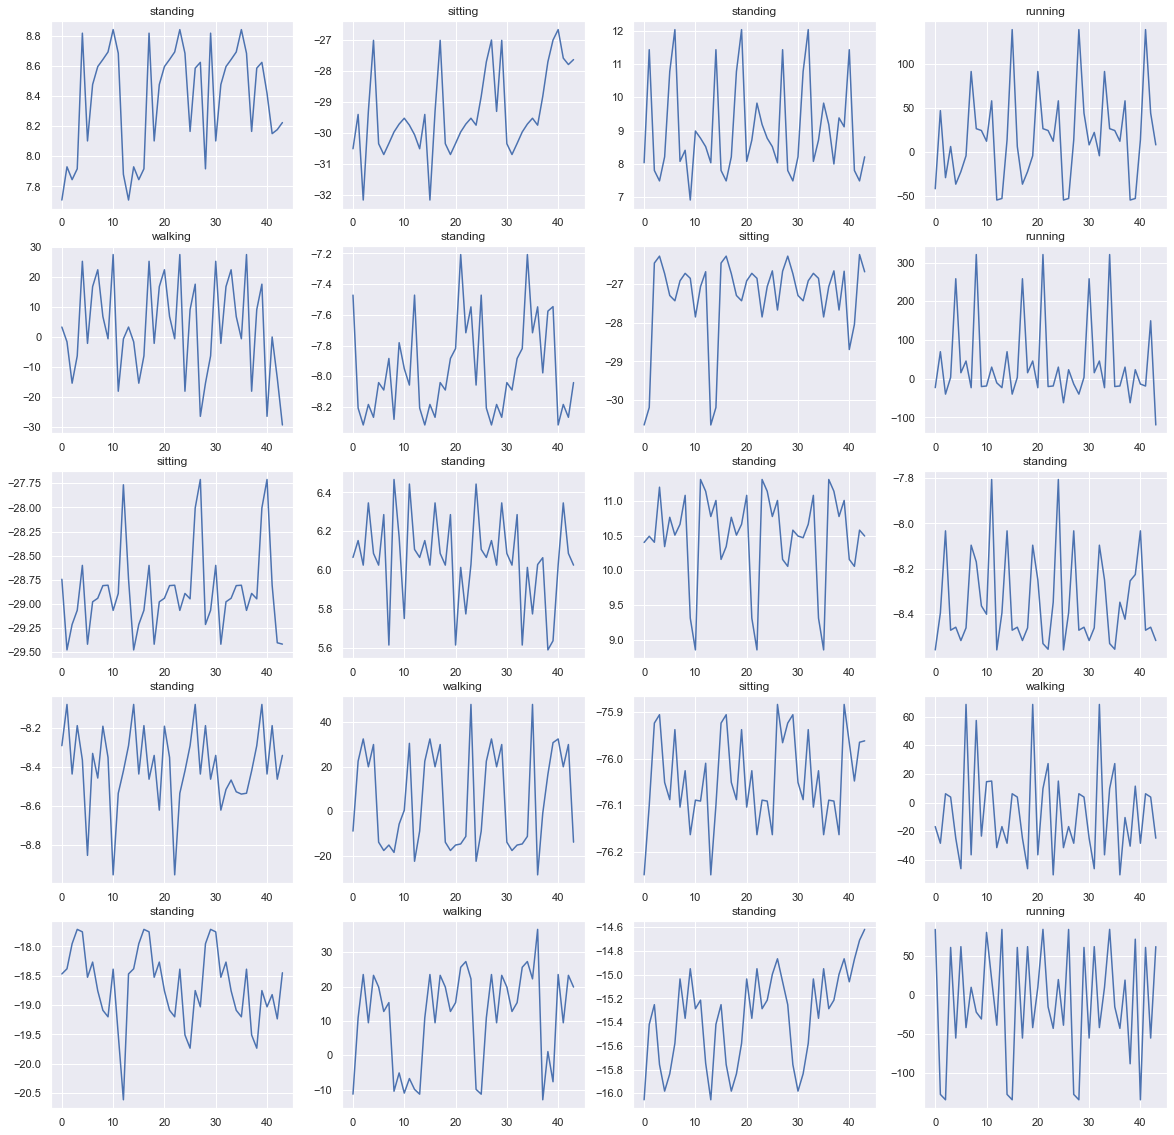

In [22]:
import random
sns.set()
for i in range(20):
    plt.subplot(5,4, i+1)
    r = random.randint(1, len(df))
    plt.plot(df_array[r,:])
    activity = act_id.iloc[r]
    activity = id_2_name[activity.values[0]]
    plt.title(activity)

fig = plt.gcf()
fig.set_size_inches(20, 20)
plt.show()


**Feature Engineering**

In the code below I take each row and make some statistical properties from each time series example

In [14]:
def make_features(chunk):
    features = {}
    dimension = 'x'
    features[dimension + '_range'] = [chunk.max() - chunk.min()]
    features[dimension + '_std']= [chunk.std()]
    peaks, _ = find_peaks(chunk)
    features[dimension + '_peak_number'] = [len(peaks)]
    features[dimension + '_sum'] = [chunk.sum()]
    q1, q3 = np.percentile(chunk, [25, 75])
    iqr = q3 - q1
    features[dimension + '_iqr'] = [iqr]
    features[dimension + '_kurtosis' ] = [kurtosis(chunk)]
    coeffs = np.polyfit(range(len(chunk)), chunk, 1)
    gradient = coeffs[0]
    features[dimension + '_gradient' ] = [gradient]
    features[dimension + '_skew' ] = [skew(chunk)]

    data = pd.DataFrame(features)
    return data


from tqdm import tqdm

count = 0
for row in tqdm(range(len(df_array))):
    if count == 0:
        dataset = make_features(df_array[row, :])
    else:
        dataset = pd.concat([dataset, make_features(df_array[row, :])])
    count += 1
    

    
    
    
    

100%|█████████████████████████████████████████████████████████████████████████████| 7776/7776 [00:13<00:00, 564.35it/s]


In [23]:
dataset

,x_range,x_std,x_peak_number,x_sum,x_iqr,x_kurtosis,x_gradient,x_skew,target
0,0.507,0.107629,14,-3229.96800,0.11700,0.174272,-0.000079,0.079455,1
1,0.236,0.057898,11,-3230.91300,0.07525,-0.580827,-0.000055,-0.129593,1
2,0.246,0.062539,16,-3230.06100,0.04200,-0.021629,0.000862,0.430905,1
3,0.354,0.074516,15,-3229.30400,0.07475,1.706842,0.000539,-0.892170,1
4,0.354,0.081967,14,-3230.01400,0.08825,0.711533,-0.000900,-0.740479,1
...,...,...,...,...,...,...,...,...,...
7771,268.240,55.525254,17,-60.62680,75.99850,0.600960,0.539436,0.343508,4
7772,268.240,61.092175,14,391.73760,65.95500,1.304544,0.071555,1.139484,4
7773,118.858,35.794623,13,-522.60916,43.93490,-0.926530,0.086812,-0.494248,4
7774,118.858,25.872605,10,-219.57003,33.82315,0.748368,0.225329,-0.502100,4


In [16]:
dataset = dataset.reset_index(drop = True)

**We add the target to the datset for EDA**

In [17]:
dataset['target'] = act_id

In [66]:
dataset.head(2)

,x_range,x_std,x_peak_number,x_sum,x_iqr,x_kurtosis,x_gradient,x_skew,target
0,0.507,0.107629,14,-3229.968,0.11700,0.174272,-0.000079,0.079455,1
1,0.236,0.057898,11,-3230.913,0.07525,-0.580827,-0.000055,-0.129593,1


**The pair plot with the hue showing the groupings can be a really quick way to get a feel for what columns the algorithm is going to most likely use to help in its classification by looking at the pairs that appear to sepparate out the classes the best**

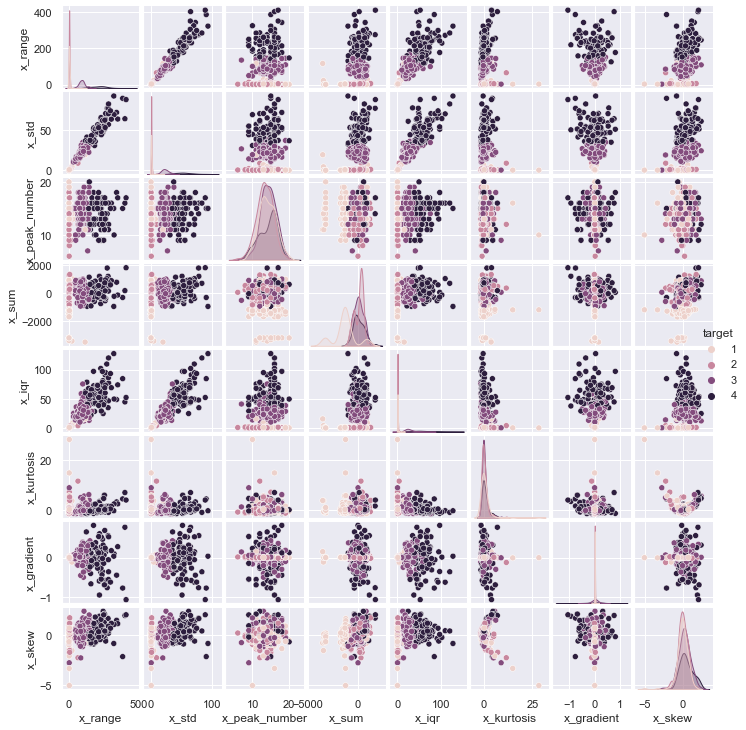

In [81]:
sns.color_palette("viridis", as_cmap=True)
sns.pairplot(dataset.sample(500), diag_kind='kde', hue="target")
fig = plt.gcf()
fig.set_size_inches(10,10)

Below we plot a correlation matrix 

A correlation matrix is a table that displays the pairwise correlations between different variables in a dataset. Each cell in the matrix represents the correlation between two variables. The correlation coefficient is a statistical measure that quantifies the strength and direction of the linear relationship between two variables. The coefficient ranges from -1 to 1, where -1 represents a perfect negative correlation, 0 represents no correlation, and 1 represents a perfect positive correlation.

The correlation matrix is useful in identifying the relationships between different variables in a dataset. For example, it can help to identify variables that are highly correlated with each other, which can indicate redundancy or multicollinearity in a regression analysis. The matrix can also help to identify variables that are strongly correlated with the target variable, which can help in feature selection for a machine learning model. Additionally, the correlation matrix can be used to identify potential confounding variables in a study by examining the correlations between the independent variables.

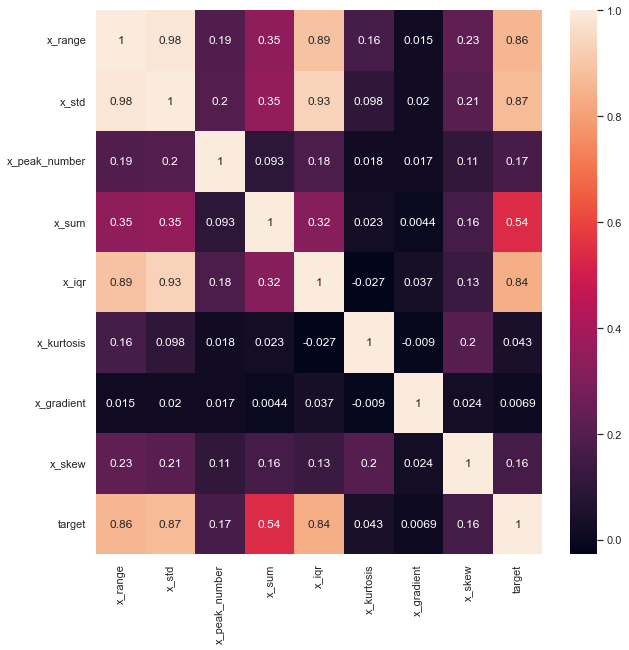

In [65]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, annot=True,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
fig = plt.gcf()
fig.set_size_inches(10, 10)

Below:

The code is a loop that creates a box plot and strip plot for each column (variable) in the input dataset. For each column, a new figure is created using the plt.figure() function. The sns.boxplot() function is then used to create a box plot, with the target variable on the x-axis and the current variable (var) on the y-axis. The boxprops parameter is set to dict(facecolor=(0,0,0,0)) to make the boxes transparent.

Next, the sns.stripplot() function is used to create a strip plot, with the target variable on the x-axis and the current variable (var) on the y-axis. The alpha parameter is set to 0.5 to adjust the transparency of the points in the strip plot.

Finally, the title of the plot is set to the name of the current variable (var) using plt.title().

The resulting plot shows the distribution of each variable across different values of the target variable, which can help to identify any patterns or differences in the distribution that are associated with different target values. The box plot shows the median, quartiles, and any outliers, while the strip plot shows the individual data points. The combination of these two plots can help to provide a more complete picture of the distribution of each variable.


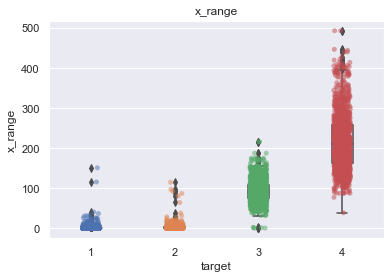

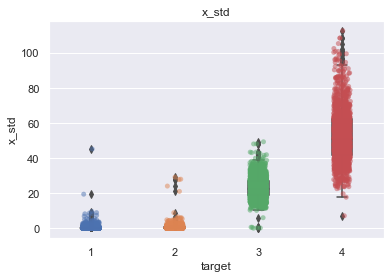

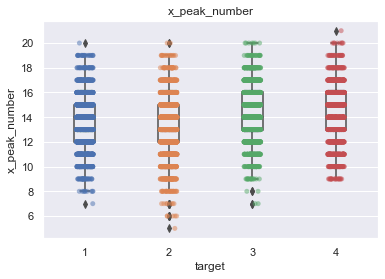

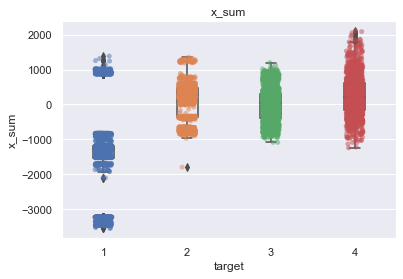

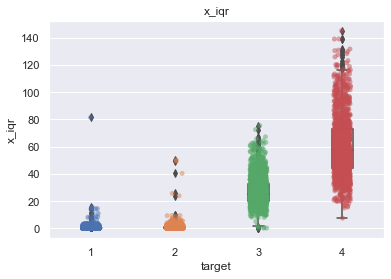

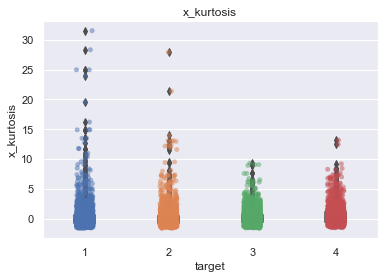

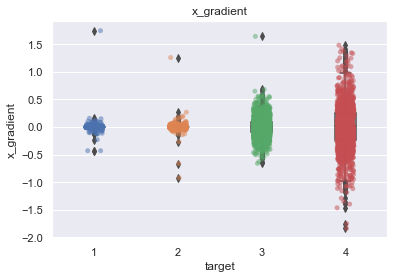

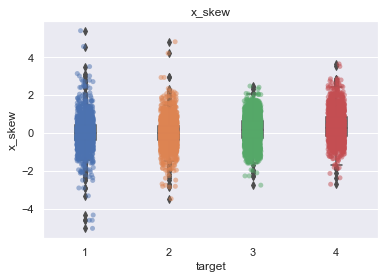

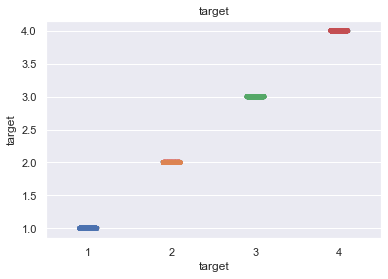

In [29]:
for var in dataset.columns:
    plt.figure() #this creates a new figure on which your plot will appear
    sns.boxplot(data=dataset,x='target', y=var,width=0.25,boxprops=dict(facecolor=(0,0,0,0)))
    sns.stripplot(data=dataset, x='target', y=var, alpha =0.5);
    plt.title(var)

Description of the code below using PCA

The first two lines import the StandardScaler class from sklearn.preprocessing and the PCA class from sklearn.decomposition. StandardScaler is a preprocessing step used to standardize the dataset by centering it around the mean and scaling it to unit variance. PCA is a dimensionality reduction technique that is used to reduce the number of dimensions of a high-dimensional dataset, while retaining the most important information.

The next two lines use the StandardScaler to scale the input dataset, with the last two columns of the dataset excluded. Then, a PCA model with 6 components is initialized and fit to the scaled dataset, and the transformed principal components are extracted and stored in a new DataFrame called principal_df.

The following lines create a scatter plot of the first two principal components, where the color of each point is determined by the target column of the original dataset. A legend is added to the plot using the legend_elements() method of the scatter plot object. The explained_variance_ratio_ attribute of the PCA object is then printed, which gives the proportion of the total variance in the original dataset that is explained by each principal component.

Finally, a bar plot is created to show the explained variance ratio for each of the 6 principal components. This plot can be used to determine the optimal number of principal components to retain in the reduced-dimensionality dataset.


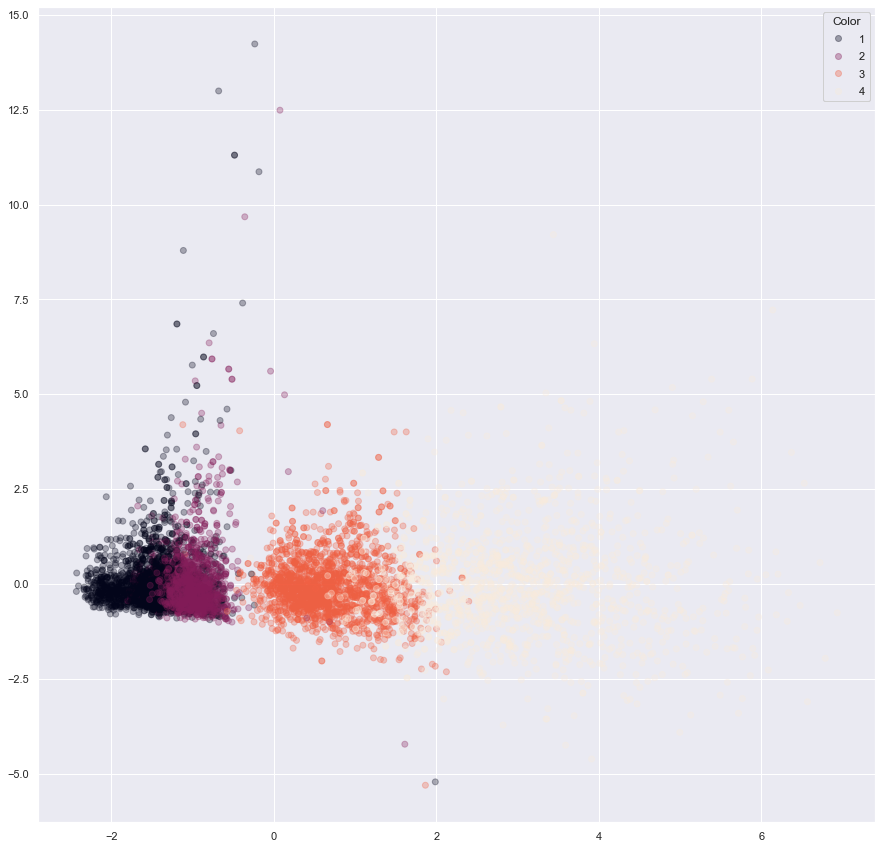

[0.44390061 0.14595483 0.14171461 0.13474678 0.11848549 0.0139191 ]


Text(0.5, 1.0, 'PCA Explained Ratio')

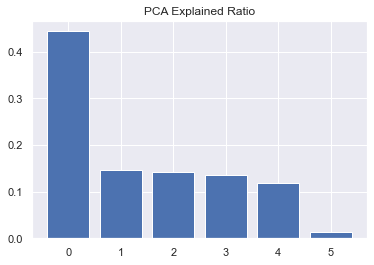

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.iloc[:, :-2])
# assuming your DataFrame is named `df`
pca = PCA(n_components=6)  # initialize PCA with 2 components
principal_components = pca.fit_transform(scaled_data)  # fit and transform the data
principal_components = principal_components[:, 0:2]
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])  # create a new DataFrame with the principal components



fig, ax = plt.subplots(figsize = (15, 15))
scatter = ax.scatter(principal_df['PC1'], principal_df['PC2'], c=dataset['target'], alpha = 0.3)
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Color")
ax.add_artist(legend)

plt.show()
explained_variances = pca.explained_variance_ratio_
print(explained_variances)


plt.bar(range(6), explained_variances)
plt.title('PCA Explained Ratio')

**The results from the pca scatter graph show us our categories are separating out quite nicely. It is an early indication that we may get good results**

The code below imports the train_test_split function from the sklearn.model_selection module, which is used to split a dataset into training and testing sets for machine learning tasks. The target_col variable is set to the name of the column in the dataset that contains the target variable or the dependent variable. The feature matrix X is created by dropping the target column from the dataset, while the target vector y is set to the target column.

The train_test_split() function is then called with the feature matrix X and target vector y, along with the desired test set size of 20% (specified using the test_size parameter) and a random state of 42 (specified using the random_state parameter). The function returns four separate objects: the training set for features X_train, the testing set for features X_test, the training set for the target variable y_train, and the testing set for the target variable y_test.

This split allows us to train a machine learning model on the training data (X_train and y_train), and then evaluate its performance on the testing data (X_test and y_test). By splitting the data into training and testing sets, we can ensure that the model is not overfitting to the training data and can generalize well to new, unseen data. The random_state parameter ensures that the same random split is used every time the code is run, which is useful for reproducibility purposes.

In [40]:
from sklearn.model_selection import train_test_split
target_col = 'target'

# Create the feature matrix (X) and the target vector (y)
X = dataset.drop(target_col, axis=1)
y = dataset[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**We are using a very basic decission tree classifier first as seen below**

In [41]:
# Define the decistion tree and its hyperparmeters
clf1 = DecisionTreeClassifier()
# Fit the above decision tee to the training data
clf1.fit(X_train, y_train)

DecisionTreeClassifier()

The code below ConfusionMatrixDisplay.from_estimator(clf1, X_train, y_train,cmap=plt.cm.Blues) creates a confusion matrix plot for a classification model clf1 using the training data X_train and y_train. The ConfusionMatrixDisplay class is a helper class in the sklearn.metrics module that can be used to display a confusion matrix using Matplotlib.

The confusion matrix is a table that shows the number of true positives, true negatives, false positives, and false negatives for each class in the classification problem. The diagonal of the matrix represents the number of correct predictions, while the off-diagonal elements represent the number of incorrect predictions. The from_estimator() method of the ConfusionMatrixDisplay class takes as input the trained classification model clf1, the training data X_train, and the corresponding target labels y_train. The optional parameter cmap is used to specify the color map for the plot.

The plt.grid(False) function call is used to remove the grid lines from the plot, which can sometimes be distracting.

The resulting confusion matrix plot shows the number of correct and incorrect predictions for each class in the classification problem, which can help to visualize the performance of the classification model. The diagonal elements (top-left to bottom-right) represent the number of correct predictions, while the off-diagonal elements represent the number of incorrect predictions. The row and column labels of the matrix correspond to the target class labels. The color of each cell represents the number of observations that fall into that category, with darker colors indicating higher values. The confusion matrix plot can be used to identify which classes are being misclassified by the model, and can help to guide future improvements to the model.

The first model is showing results on the training data (the data the model was trained on) and the second is on the testing data (unseen data). A good model the results will be similar. We see big difference that indicates overfitting on the trainig data

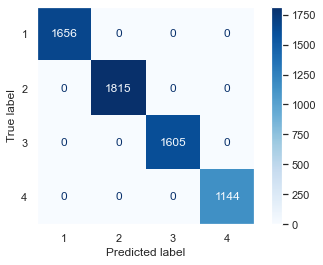

In [42]:
ConfusionMatrixDisplay.from_estimator(clf1, X_train, y_train,cmap=plt.cm.Blues)
plt.grid(False);

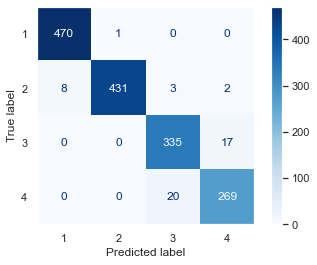

In [43]:
ConfusionMatrixDisplay.from_estimator(clf1, X_test, y_test,cmap=plt.cm.Blues)
plt.grid(False);

The code below performs hyperparameter tuning for a Decision Tree Classifier using Grid Search Cross-Validation (GridSearchCV) from the sklearn library in Python.

The param_grid dictionary contains a range of values for the hyperparameters of the Decision Tree Classifier. Specifically, max_depth is a hyperparameter that controls the maximum depth of the tree, and min_samples_leaf is a hyperparameter that controls the minimum number of samples required to be at a leaf node. The range() function is used to specify a range of values for min_samples_leaf, while a list of values is used for max_depth.

The cv parameter specifies the cross-validation strategy to be used. In this case, StratifiedKFold is used with 5 splits. This means that the data is split into 5 equal parts, and each part is used as a test set exactly once, while the rest are used for training. The StratifiedKFold ensures that each split has the same proportion of target classes as the original dataset.

The DecisionTreeClassifier() method is used to create a Decision Tree Classifier object. The GridSearchCV() function is then used to perform hyperparameter tuning using the given hyperparameter grid (param_grid), cross-validation strategy (cv), and the Decision Tree Classifier object. The verbose parameter is set to 1, which means that progress messages are printed to the console. The refit parameter is set to True, which means that the best model is refitted on all the training data after the hyperparameters are selected, so that it can be used for making predictions on new data. The n_jobs parameter is set to -1, which means that all available CPU cores are used for computation. Finally, the scoring parameter is set to 'accuracy', which is a metric used to evaluate the performance of the model.

The fit() method of the GridSearchCV object is then called with the training data X_train and y_train. This fits the Decision Tree Classifier on all possible combinations of hyperparameters, and selects the best hyperparameters based on the accuracy score. The resulting best estimator model can be accessed using the best_estimator_ attribute of the GridSearchCV object.

In [61]:
param_grid = {'max_depth' : [2, 3, 4, 5, 6, 7],       # increase the range up to 10
              'min_samples_leaf': range(1,10)} # increase the range up to 30

cv = StratifiedKFold(n_splits=5) #"Generate test sets such that all contain the same distribution of classes, or as close as possible." https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold

tree= DecisionTreeClassifier()
grid1 = GridSearchCV(tree,
                    param_grid=param_grid,
                    cv=cv,
                    verbose=1,
                    refit=True, # Refits the best model on all the training data so you can use grid1 to make predictions (default argument)
                    n_jobs=-1, # -1 means using all processors
                    scoring='accuracy') # https://scikit-learn.org/stable/modules/model_evaluation.html
grid1.fit(X_train,y_train)                    

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': range(1, 10)},
             scoring='accuracy', verbose=1)

In [62]:
grid1_results = pd.DataFrame.from_dict(grid1.cv_results_)
grid1_results.sort_values(by=['rank_test_score']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.032536,0.009557,0.001604,0.000592,5,9,"{'max_depth': 5, 'min_samples_leaf': 9}",0.960611,0.967042,0.977492,0.978296,0.965434,0.969775,0.006963,1
34,0.029275,0.009858,0.003695,0.003422,5,8,"{'max_depth': 5, 'min_samples_leaf': 8}",0.963023,0.968650,0.969453,0.978296,0.965434,0.968971,0.005200,2
26,0.032300,0.009697,0.002083,0.000331,4,9,"{'max_depth': 4, 'min_samples_leaf': 9}",0.962219,0.968650,0.973473,0.975884,0.963826,0.968810,0.005293,3
24,0.021358,0.002101,0.001922,0.000208,4,7,"{'max_depth': 4, 'min_samples_leaf': 7}",0.962219,0.968650,0.973473,0.975884,0.963826,0.968810,0.005293,3
25,0.023468,0.003597,0.001501,0.000446,4,8,"{'max_depth': 4, 'min_samples_leaf': 8}",0.962219,0.968650,0.973473,0.975884,0.963826,0.968810,0.005293,3


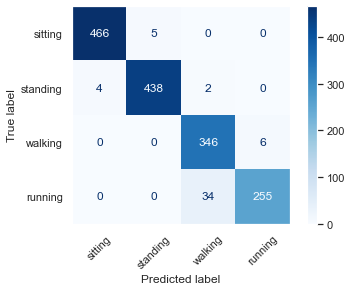

In [63]:
disp = ConfusionMatrixDisplay.from_estimator(grid1, X_test, y_test, cmap=plt.cm.Blues)

# Set custom tick labels for the x and y axes
tick_labels = ['sitting', 'standing', 'walking', 'running']
disp.ax_.set_xticklabels(tick_labels, rotation=45)
disp.ax_.set_yticklabels(tick_labels)

# Remove the grid lines from the plot
plt.grid(False)

# Show the plot
plt.show()

In [64]:
y_pred = final.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       471
           2       1.00      0.97      0.99       444
           3       0.93      0.97      0.95       352
           4       0.96      0.93      0.95       289

    accuracy                           0.97      1556
   macro avg       0.97      0.97      0.97      1556
weighted avg       0.97      0.97      0.97      1556



## Advanced Hyper Param Tuning across multiple algorithms

The given code is an implementation of a machine learning pipeline for several classification algorithms, where hyperparameter tuning is performed using Grid Search Cross-Validation (GridSearchCV) from the sklearn library in Python.

The code defines several hyperparameter grids for different classification algorithms, such as Decision Tree (DT), Support Vector Machine (SVM), Random Forest (RF), Logistic Regression (log_reg), XGBoost (xgb), and k-Nearest Neighbors (knn). The hyperparameter grids contain a range of values for different hyperparameters of each algorithm, such as the maximum depth of a tree, the number of estimators in an ensemble, the learning rate of a boosting algorithm, and so on.

The code then defines a dictionary called algorithms, which maps each algorithm name to a list of its corresponding classifier, a boolean value indicating whether the data should be normalized, and the corresponding hyperparameter grid.

Next, a loop is implemented over the keys in the algorithms dictionary, where the classifier and the hyperparameter grid are extracted based on the current key. The GridSearchCV function is then used to perform hyperparameter tuning using the given hyperparameter grid and a repeated stratified k-fold cross-validation scheme. The best hyperparameters are then extracted, and the resulting model is used to make predictions on the test data. Finally, the performance metrics such as accuracy, f1-score, precision, and recall are calculated and stored in a DataFrame called results.

The results DataFrame is then concatenated with the results from all other algorithms, and the resulting DataFrame is sorted based on the mean f1-score. Finally, the results DataFrame is printed to the console.

Overall, the code performs a comprehensive hyperparameter tuning pipeline for several classification algorithms, where the best model is selected based on its f1-score.

In [46]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [47]:
dt_params = {'max_depth' : range(2,8, 2),  'min_samples_leaf': range(5,10, 2)}

svm_params ={'C': [ 1, 0.01, 0.0001],
             'gamma': ['scale', 'auto'],
             'kernel': ['linear', 'rbf']}
rf_params = {'n_estimators': [10, 100, 300],
             'max_depth': [5, 10, 15],
             'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [ 1, 3, 5]}
gb_params = {
    "n_estimators": [1, 5, 10, 50, 200],
    "max_leaf_nodes": [2, 5, 10],
    "learning_rate": [0.01, 0.1, 1]}            

log_r_params = {'penalty': ['l1', 'l2', 'none'],
         'C': [ 1, 0.01, 0.0001]}

xgb_params = {'gamma': [0,1],
              'learning_rate': [0.01,0.1, 1],
              'max_depth': [5,10, 15]}
              # 'n_estimators': [50,100, 150],
              # 'reg_alpha': [0,0.1,1, 50, 100],
              # 'reg_lambda': [0,0.1,1, 100]}
            
knn_params = {'n_neighbors' : [1, 3, 5, 7, 9, 15, 19]}



In [48]:
algorithms = {'log_reg': [LogisticRegression(), False, log_r_params],
              'DT' :[DecisionTreeClassifier(), False, dt_params],
              'svm': [svm.SVC(), True,  svm_params],
             'RF': [RandomForestClassifier(), False, rf_params]}
             # 'gradeint boosting' : [GradientBoostingClassifier(),False,  gb_params],
             # 'xgb': [xgb.XGBClassifier(), False,  xgb_params]}
             # 'knn':[KNeighborsClassifier(), True, knn_params]} 

results = pd.DataFrame(columns = [ 'name', 'params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall'])


for i in tqdm(range(len(list(algorithms.keys())))):
    alg = list(algorithms.keys())[i]
    print('staring :', alg)
    clf = algorithms[alg][0]
    param_grid = algorithms[alg][2]
    print(param_grid)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
    grid1 = GridSearchCV(clf,
                    param_grid=param_grid,
                    cv=cv,
                    verbose=1,
                    refit=False, # Refits the best model on all the training data so you can use grid1 to make predictions (default argument)
                    n_jobs=-1, # -1 means using all processors
                    scoring=['accuracy'])
    normalisation = algorithms[alg][1]
    if normalisation:
        scaler.fit(X_train)
        grid1.fit(scaler.transform(X_train), y_train)  
    else:
        print('no normalisation')
        grid1.fit(X_train, y_train)  
        
    grid1_results = pd.DataFrame.from_dict(grid1.cv_results_)
    grid1_results = grid1_results[['params', 'mean_test_accuracy']].sort_values(
        by = 'mean_test_accuracy', ascending = False).reset_index(drop = True)
    grid1_results['name'] = pd.DataFrame([alg]*len(grid1_results))
    results = pd.concat([results, grid1_results]).sort_values(
        by = 'mean_test_f1', ascending = False).reset_index(drop = True)
    results.reset_index(drop = True, inplace = True)
    print('completed: ', alg)
print('fitted all models and parameters')
    

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

staring : log_reg
{'penalty': ['l1', 'l2', 'none'], 'C': [1, 0.01, 0.0001]}
no normalisation
Fitting 3 folds for each of 9 candidates, totalling 27 fits


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00,  4.35it/s]

completed:  log_reg
staring : DT
{'max_depth': range(2, 8, 2), 'min_samples_leaf': range(5, 10, 2)}
no normalisation
Fitting 3 folds for each of 9 candidates, totalling 27 fits
completed:  DT
staring : svm
{'C': [1, 0.01, 0.0001], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:10<00:04,  4.52s/it]

completed:  svm
staring : RF
{'n_estimators': [10, 100, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 5]}
no normalisation
Fitting 3 folds for each of 81 candidates, totalling 243 fits


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.01s/it]

completed:  RF
fitted all models and parameters


**Sort the results by the best perormance**

In [50]:
results.sort_values(by = 'mean_test_accuracy', ascending = False)

,name,params,mean_test_accuracy,mean_test_f1,mean_test_precision,mean_test_recall
30,RF,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.977009,NaN,NaN,NaN
31,RF,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.976688,NaN,NaN,NaN
32,RF,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.976366,NaN,NaN,NaN
33,RF,"{'max_depth': 15, 'min_samples_leaf': 1, 'min_...",0.975723,NaN,NaN,NaN
34,RF,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.974759,NaN,NaN,NaN
...,...,...,...,...,...,...
29,svm,"{'C': 0.0001, 'gamma': 'auto', 'kernel': 'rbf'}",0.291801,NaN,NaN,NaN
28,svm,"{'C': 0.0001, 'gamma': 'scale', 'kernel': 'rbf'}",0.291801,NaN,NaN,NaN
6,log_reg,"{'C': 1, 'penalty': 'l1'}",NaN,NaN,NaN,NaN
7,log_reg,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN,NaN


**View the results for each algorithm as a graph**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


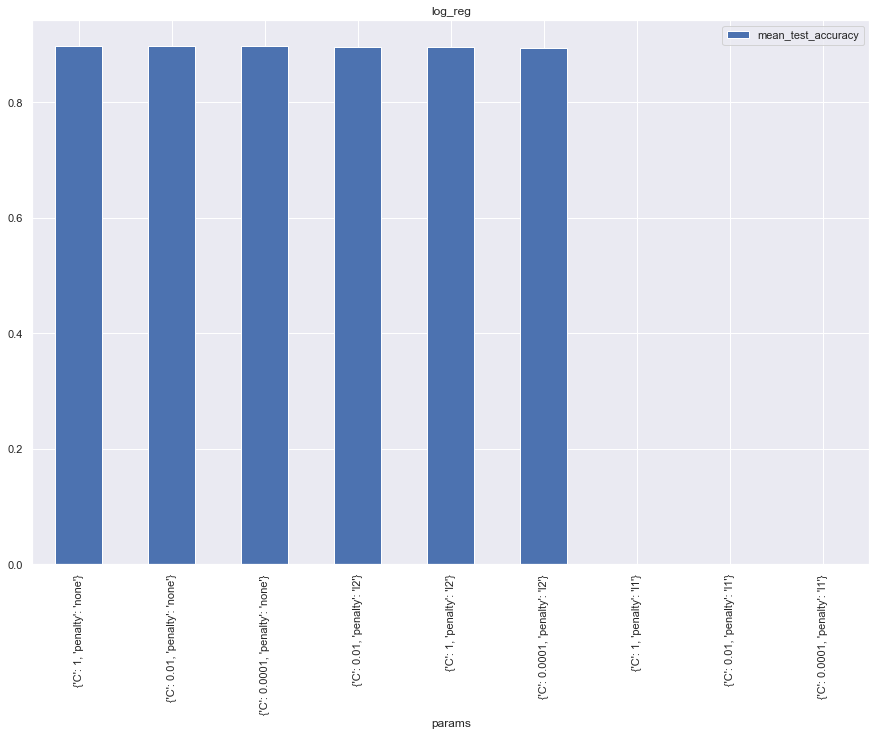

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


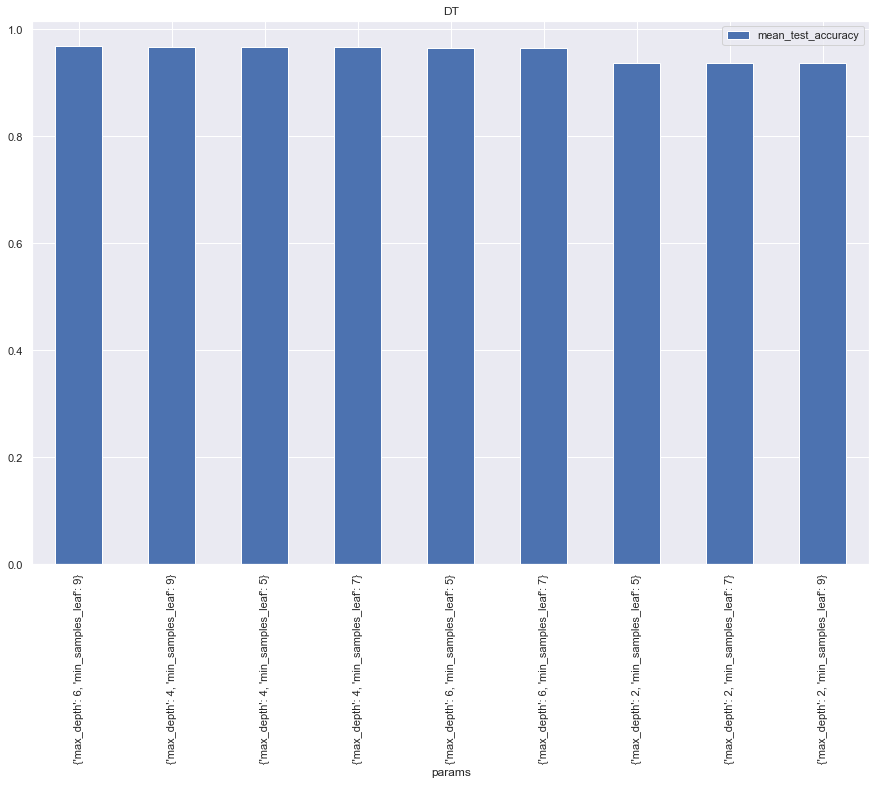

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


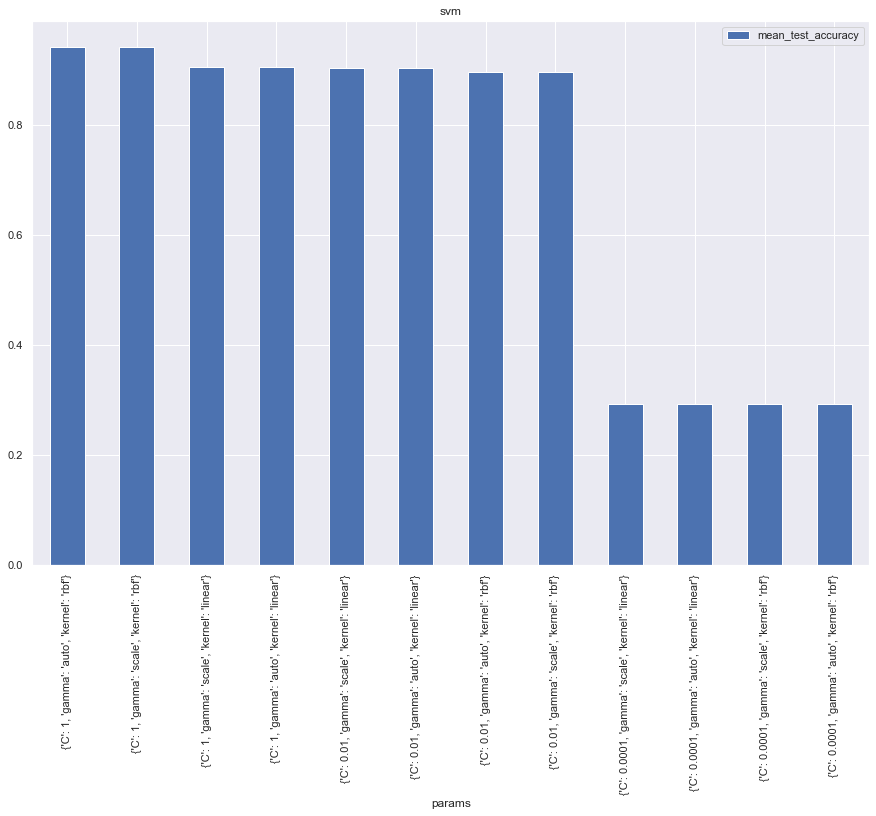

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

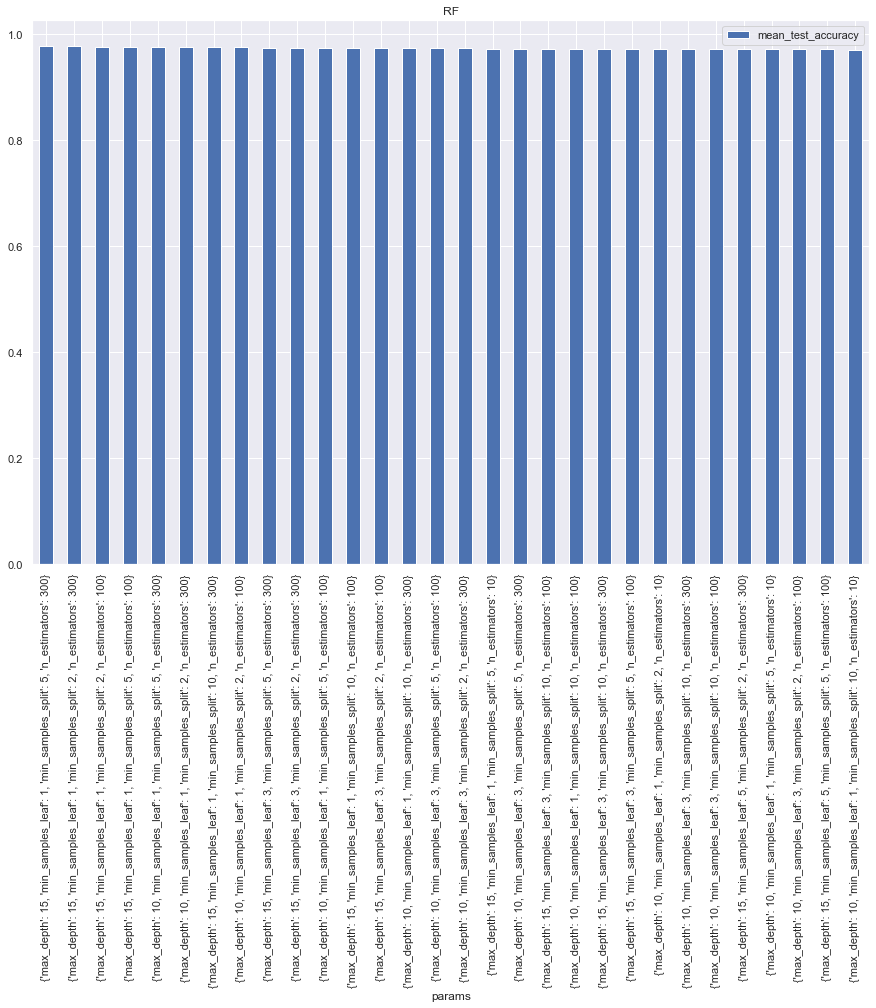

In [51]:
for alg in list(results.name.unique()):
    plt_df = results[results['name'] == alg]
    plt_df = plt_df.head(30)
    plt_df.plot(kind  = 'bar', x = str('params'), y = 'mean_test_accuracy')
    xlocs, xlabs = plt.xticks()
    xlocs=[i+1 for i in range(0,len(plt_df))]
    xlabs=[i/2 for i in range(0,len(plt_df))]
    for i, v in enumerate(plt_df.mean_test_f1):
        plt.text(xlocs[i]-1.5, v , str(v)[0:4])
    plt.title(alg)
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.show()
    

**Take the best performing clasifier and train the algorithm on that**

In [52]:
best_params = results.sort_values(by = 'mean_test_accuracy', ascending = False).iloc[0]
final = RandomForestClassifier(**best_params.params)
final.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=300)

**Create a Confusion Matrix based on the test data**

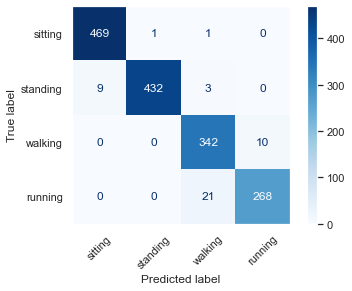

In [58]:
disp = ConfusionMatrixDisplay.from_estimator(final, X_test, y_test, cmap=plt.cm.Blues)

# Set custom tick labels for the x and y axes
tick_labels = ['sitting', 'standing', 'walking', 'running']
disp.ax_.set_xticklabels(tick_labels, rotation=45)
disp.ax_.set_yticklabels(tick_labels)

# Remove the grid lines from the plot
plt.grid(False)

# Show the plot
plt.show()

In [59]:
y_pred = final.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       471
           2       1.00      0.97      0.99       444
           3       0.93      0.97      0.95       352
           4       0.96      0.93      0.95       289

    accuracy                           0.97      1556
   macro avg       0.97      0.97      0.97      1556
weighted avg       0.97      0.97      0.97      1556



**Conclusion: 97% accurate overall however the classifier was most confused between running and walking**